# Assignment 2 - Basic Machine Learning to predict Pokémon battles results

([From Wikipedia](https://en.wikipedia.org/wiki/Pok%C3%A9mon)) *Pokémon is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996,[4] and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport.*

In this assignment we present you a dataset with the results of several Pokémon battles.

Your objective will be to produce a ML model that can predict the outcomes of any Pokémon battle.

At first, in this notebook, you will apply some of the basic ML approaches that we have seen in class. At this point you can also work with the *small* versions of the dataset if you want.

Later, on the `pokemon-competition.ipynb` notebook, you will train a model using all the data that will be used to predict *real* Pokémon battles.

**Dataset Description**

Within the `datasets.zip` file that you can download from the virtual campus, you will find the following datasets:

- data.train -> Full data available to train the models
- data_inverse.train -> Same data as data.train but each combat is seen from the other player's perspective (i.e. pokemon1 becomes pokemon2 and viceversa)
- small.train -> Subsample of data.train to allow fast prototyping
- small_inverse.train -> Subsample of data_inverse.train to allow fast prototyping
- data.hidden -> Dataset with no label available
- data_inverse.hidden -> Same as data.hidden but the pokemons are inverted

The datasets *.hidden are the ones used to get the tournament score,
so the true label is unknown. All the other datasets are available to
you to use however you want.

*Gotta Train 'Em All!*

### Dependencies

In [1]:
# Install all the required libraries
# %pip install pandas 
# %pip install numpy  
# %pip install matplotlib 
# %pip install seaborn
# %pip install sklearn    
# %pip install scipy  
# %pip install statsmodels    
# %pip install tensorflow 
# %pip install keras
# %pip install torch

In [1]:
# Add your imports here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from os import sep

# import torch
# from torch.autograd import Variable
# import torch.nn as nn
# import torch.optim as optim

from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score as accuracy_score
from sklearn.metrics import confusion_matrix as confusion_matrix

In [2]:
from pathlib import Path
import pandas

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "data.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data_inverse.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

### First view

In [3]:
data.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
39087,Karrablast,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,5.0,...,NaN,50.0,53.0,43.0,47.0,27.0,40.0,5.0,False,True
30893,NaN,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,1.0,...,NaN,65.0,64.0,NaN,49.0,41.0,39.0,5.0,False,True
45278,Mega Manectric,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,3.0,...,NaN,NaN,48.0,78.0,NaN,83.0,75.0,5.0,False,True
16398,Bouffalant,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,5.0,...,NaN,75.0,108.0,101.0,39.0,68.0,106.0,NaN,False,False
13653,Swablu,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,3.0,...,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,1.0,False,False


In [4]:
inverse_data.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
39087,Pidove,Normal,NaN,50.0,53.0,43.0,47.0,27.0,40.0,5.0,...,NaN,50.0,72.0,39.0,39.0,42.0,55.0,5.0,False,False
30893,Tepig,Fire,NaN,65.0,64.0,NaN,49.0,41.0,39.0,5.0,...,Water,70.0,NaN,125.0,113.0,78.0,NaN,1.0,False,False
45278,Garbodor,Poison,NaN,NaN,48.0,78.0,NaN,83.0,75.0,5.0,...,NaN,70.0,77.0,81.0,NaN,91.0,136.0,3.0,NaN,False
16398,Tauros,Normal,NaN,75.0,108.0,101.0,39.0,68.0,106.0,NaN,...,NaN,95.0,121.0,NaN,39.0,85.0,NaN,5.0,False,True
13653,Mr. Mime,Psychic,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,1.0,...,Flying,45.0,36.0,58.0,37.0,76.0,56.0,3.0,False,True


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               36006 non-null  object 
 1   Type 1             36026 non-null  object 
 2   Type 2             19465 non-null  object 
 3   HP                 35994 non-null  float64
 4   Attack             36103 non-null  float64
 5   Defense            35966 non-null  float64
 6   Sp. Atk            36080 non-null  float64
 7   Sp. Def            36018 non-null  float64
 8   Speed              36028 non-null  float64
 9   Generation         36007 non-null  float64
 10  Legendary          36019 non-null  object 
 11  Name__other        36037 non-null  object 
 12  Type 1__other      35990 non-null  object 
 13  Type 2__other      19406 non-null  object 
 14  HP__other          35895 non-null  float64
 15  Attack__other      36005 non-null  float64
 16  Defense__other    

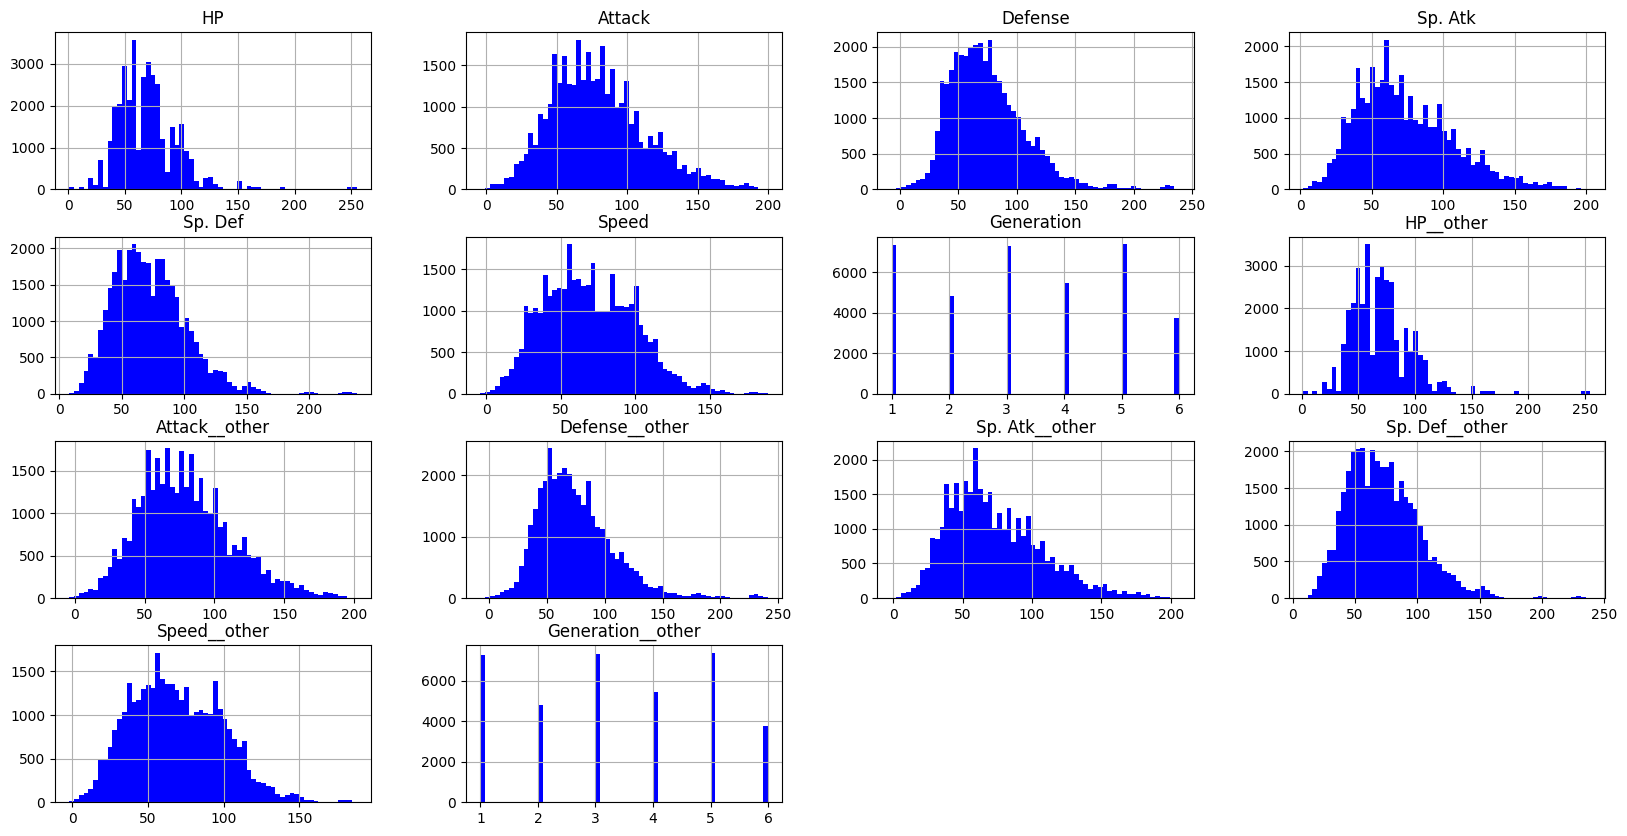

In [12]:
data.hist(bins=60, figsize=(20,10), color='b')  
plt.show()

## Part 1 - Analyze the dataset (2 points)
The first step of any ML process is to know the data we are dealing with. In this part, you have to analyze the dataset and answer the questions below.

1. Which features are categorical? Which are continuous?

In [13]:
data.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
39087,Karrablast,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,5.0,...,NaN,50.0,53.0,43.0,47.0,27.0,40.0,5.0,False,True
30893,NaN,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,1.0,...,NaN,65.0,64.0,NaN,49.0,41.0,39.0,5.0,False,True
45278,Mega Manectric,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,3.0,...,NaN,NaN,48.0,78.0,NaN,83.0,75.0,5.0,False,True
16398,Bouffalant,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,5.0,...,NaN,75.0,108.0,101.0,39.0,68.0,106.0,NaN,False,False
13653,Swablu,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,3.0,...,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,1.0,False,False


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               36006 non-null  object 
 1   Type 1             36026 non-null  object 
 2   Type 2             19465 non-null  object 
 3   HP                 35994 non-null  float64
 4   Attack             36103 non-null  float64
 5   Defense            35966 non-null  float64
 6   Sp. Atk            36080 non-null  float64
 7   Sp. Def            36018 non-null  float64
 8   Speed              36028 non-null  float64
 9   Generation         36007 non-null  float64
 10  Legendary          36019 non-null  object 
 11  Name__other        36037 non-null  object 
 12  Type 1__other      35990 non-null  object 
 13  Type 2__other      19406 non-null  object 
 14  HP__other          35895 non-null  float64
 15  Attack__other      36005 non-null  float64
 16  Defense__other    

In [15]:
data.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other
count,35994.000000,36103.000000,35966.000000,36080.000000,36018.000000,36028.000000,36007.000000,35895.000000,36005.000000,35984.000000,35904.000000,35995.000000,35956.000000,36014.000000
mean,69.771879,79.254023,74.663933,73.425139,72.465434,68.790441,3.333630,69.838418,79.254909,74.787961,73.168951,72.582525,68.781622,3.337702
std,26.610838,33.408366,32.402967,33.507089,28.982072,30.178166,1.656558,26.604671,33.160915,32.456015,33.486762,28.986777,29.998563,1.654265
min,1.000000,-4.000000,-7.000000,2.000000,8.000000,-4.000000,1.000000,1.000000,-4.000000,-7.000000,-1.000000,8.000000,-2.000000,1.000000
25%,50.000000,55.000000,51.000000,48.000000,51.000000,46.000000,2.000000,50.000000,55.000000,52.000000,48.000000,51.000000,46.000000,2.000000
50%,65.000000,76.000000,70.000000,67.000000,69.000000,66.000000,3.000000,65.000000,76.000000,70.000000,67.000000,69.000000,66.000000,3.000000
75%,81.000000,99.000000,92.000000,95.000000,90.000000,91.000000,5.000000,82.000000,99.000000,92.000000,94.000000,90.000000,91.000000,5.000000
max,255.000000,200.000000,239.000000,203.000000,238.000000,189.000000,6.000000,255.000000,202.000000,241.000000,206.000000,239.000000,188.000000,6.000000


2. Observe the distribution of the "Type 1" variable. Use a plot to show this distribution.

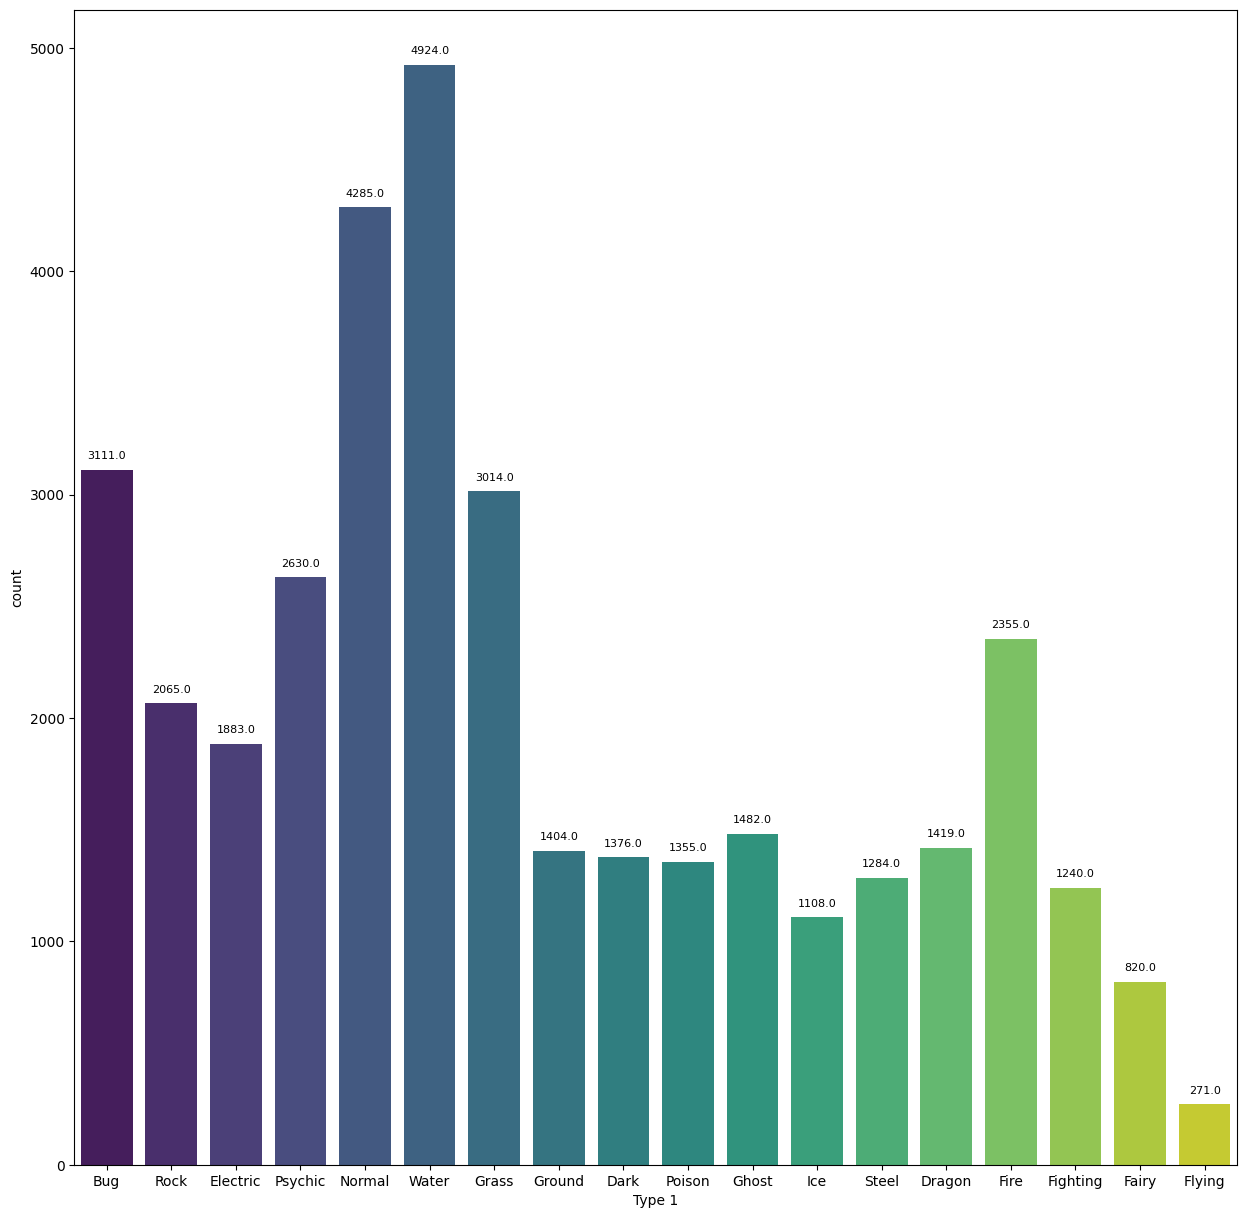

In [16]:

plt.figure(figsize=(15, 15))
sns.countplot(data=data, x='Type 1', palette='viridis')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.show()

3. Determine which of the features have missing values. How many missing values there are for each one?

In [17]:
data.isna().sum()

Name                  3994
Type 1                3974
Type 2               20535
HP                    4006
Attack                3897
Defense               4034
Sp. Atk               3920
Sp. Def               3982
Speed                 3972
Generation            3993
Legendary             3981
Name__other           3963
Type 1__other         4010
Type 2__other        20594
HP__other             4105
Attack__other         3995
Defense__other        4016
Sp. Atk__other        4096
Sp. Def__other        4005
Speed__other          4044
Generation__other     3986
Legendary__other      3982
Wins                     0
dtype: int64

4. Analize the distribution of the target column. Is it balanced?

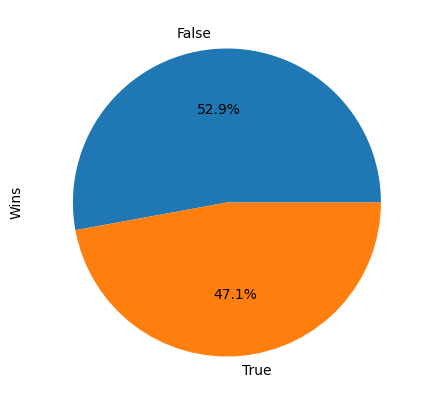

In [18]:
data['Wins'].value_counts()

plt.figure(figsize=(5,5))
data['Wins'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

## Part 2 - Preprocess the data (3 points)
Once we know how the dataset is, we can proceed with the cleaning of the data. This includes:

- Select the features that you want to use (p.e. removing too specific features). Explain why each feature is used or discarded.
- Impute the missing values. Explain why you use this imputer and not another one. If you use different imputers for different features, explain the reason why you do this.
- Encode the values of the features to work with the model you choose. This can be either encoding the categorical values, or discretizing continuous values.

### 🟢 2.1 - Imput missing values
**Problem**: ...    
**Objective**: ...      
**Process**: ...

In [19]:
# Make a copy of the data
data_1 = data.copy(deep=True)

#### -> Delete rows without Name or Name__other

In [20]:
# Elimina filas con NaN en la columna 'Name' y 'Name__other'
data_1.dropna(subset=['Name'], inplace=True)    
data_1['Name'].isna().sum() 

0

In [21]:
data_1.dropna(subset=['Name__other'], inplace=True)     
data_1['Name__other'].isna().sum()

0

#### -> Fill statistics with the mean of the same Pokemon

In [22]:
data_1['HP'].isna().sum()

3238

In [23]:
data_1['HP'] = data_1.groupby('Name')['HP'].transform(lambda x: x.fillna(x.mean())) 
data_1['HP'].isna().sum()

0

In [24]:
data_1.isna().sum()

Name                     0
Type 1                3231
Type 2               16664
HP                       0
Attack                3160
Defense               3232
Sp. Atk               3151
Sp. Def               3228
Speed                 3214
Generation            3191
Legendary             3210
Name__other              0
Type 1__other         3283
Type 2__other        16660
HP__other             3303
Attack__other         3206
Defense__other        3263
Sp. Atk__other        3336
Sp. Def__other        3286
Speed__other          3294
Generation__other     3192
Legendary__other      3243
Wins                     0
dtype: int64

In [25]:
# Pokemon 1
columns_to_fill = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
data_1[columns_to_fill] = data_1.groupby('Name')[columns_to_fill].transform(lambda x: x.fillna(x.mean()))   

# Pokemon 2
columns_to_fill = ['HP__other', 'Attack__other', 'Defense__other', 'Sp. Atk__other', 'Sp. Def__other', 'Speed__other']
data_1[columns_to_fill] = data_1.groupby('Name__other')[columns_to_fill].transform(lambda x: x.fillna(x.mean()))   

data_1.isna().sum()

Name                     0
Type 1                3231
Type 2               16664
HP                       0
Attack                   0
Defense                  0
Sp. Atk                  0
Sp. Def                  0
Speed                    0
Generation            3191
Legendary             3210
Name__other              0
Type 1__other         3283
Type 2__other        16660
HP__other                0
Attack__other            0
Defense__other           0
Sp. Atk__other           0
Sp. Def__other           0
Speed__other             0
Generation__other     3192
Legendary__other      3243
Wins                     0
dtype: int64

#### -> Fill empty Types based on Name

In [26]:
data_1.isna().sum()

Name                     0
Type 1                3231
Type 2               16664
HP                       0
Attack                   0
Defense                  0
Sp. Atk                  0
Sp. Def                  0
Speed                    0
Generation            3191
Legendary             3210
Name__other              0
Type 1__other         3283
Type 2__other        16660
HP__other                0
Attack__other            0
Defense__other           0
Sp. Atk__other           0
Sp. Def__other           0
Speed__other             0
Generation__other     3192
Legendary__other      3243
Wins                     0
dtype: int64

In [27]:
# Llenar NaN en "Type 1" y "Type 2" basándote en el mismo "Name" o "Name__other"
def fill_types(row):
    if pd.isna(row["Type 1"]) and pd.isna(row["Type 2"]):
        # Buscar un Pokémon con el mismo "Name" que tenga valores en "Type 1" o "Type 2"
        matching_pokemon = data_1[(data_1["Name"] == row["Name"]) & (~data_1["Type 1"].apply(lambda x: pd.isna(x)) | ~data_1["Type 2"].apply(lambda x: pd.isna(x)))]

        if not matching_pokemon.empty:
            # Copiar los valores de "Type 1" y "Type 2" del primer Pokémon encontrado
            row["Type 1"] = matching_pokemon.iloc[0]["Type 1"]
            row["Type 2"] = matching_pokemon.iloc[0]["Type 2"]
        else:
            # Si no se encuentra un Pokémon coincidente, buscar en "Name__other"
            matching_pokemon_other = data_1[(data_1["Name__other"] == row["Name"]) & (~data_1["Type 1__other"].apply(lambda x: pd.isna(x)) | ~data_1["Type 2__other"].apply(lambda x: pd.isna(x)))]

            if not matching_pokemon_other.empty:
                # Copiar los valores de "Type 1__other" y "Type 2__other" del primer Pokémon encontrado en la segunda búsqueda
                row["Type 1"] = matching_pokemon_other.iloc[0]["Type 1__other"]
                row["Type 2"] = matching_pokemon_other.iloc[0]["Type 2__other"]
    
    return row

# Aplicar la función a cada fila del DataFrame
data_1 = data_1.apply(fill_types, axis=1)

In [28]:
# Llenar NaN en "Type 1__ohter" y "Type 2__other" basándote en el mismo "Name__other" o "Name"
def fill_types_other(row):
    if pd.isna(row["Type 1__other"]) and pd.isna(row["Type 2__other"]):
        # Buscar un Pokémon con el mismo "Name__other" que tenga valores en "Type 1" o "Type 2"
        matching_pokemon_other = data_1[(data_1["Name__other"] == row["Name__other"]) & (~data_1["Type 1"].apply(lambda x: pd.isna(x)) | ~data_1["Type 2"].apply(lambda x: pd.isna(x)))]

        if not matching_pokemon_other.empty:
            # Copiar los valores de "Type 1" y "Type 2" del primer Pokémon encontrado
            row["Type 1__other"] = matching_pokemon_other.iloc[0]["Type 1"]
            row["Type 2__other"] = matching_pokemon_other.iloc[0]["Type 2"]
        else:
            # Si no hay matching_pokemon_other, buscar matching_pokemon
            matching_pokemon = data_1[(data_1["Name"] == row["Name"]) & (~data_1["Type 1"].apply(lambda x: pd.isna(x)) | ~data_1["Type 2"].apply(lambda x: pd.isna(x)))]

            if not matching_pokemon.empty:
                # Copiar los valores de "Type 1" y "Type 2" del primer Pokémon encontrado
                row["Type 1__other"] = matching_pokemon.iloc[0]["Type 1"]
                row["Type 2__other"] = matching_pokemon.iloc[0]["Type 2"]
    
    return row

# Aplicar la función a cada fila del DataFrame
data_1 = data_1.apply(fill_types_other, axis=1)

In [29]:
data_1.isna().sum()

Name                     0
Type 1                1552
Type 2               16362
HP                       0
Attack                   0
Defense                  0
Sp. Atk                  0
Sp. Def                  0
Speed                    0
Generation            3191
Legendary             3210
Name__other              0
Type 1__other         1661
Type 2__other        15905
HP__other                0
Attack__other            0
Defense__other           0
Sp. Atk__other           0
Sp. Def__other           0
Speed__other             0
Generation__other     3192
Legendary__other      3243
Wins                     0
dtype: int64

#### -> Type 2 from Type 1 and vice versa

In [30]:
# Llena los valores faltantes en 'Type 2' con los valores correspondientes de 'Type 1'
data_1['Type 2'].fillna(data_1['Type 1'], inplace=True) 
data_1['Type 1'].fillna(data_1['Type 2'], inplace=True)     

data_1['Type 2__other'].fillna(data_1['Type 1__other'], inplace=True) 
data_1['Type 1__other'].fillna(data_1['Type 2__other'], inplace=True)     

In [31]:
data_1.isna().sum()

Name                    0
Type 1                  0
Type 2                  0
HP                      0
Attack                  0
Defense                 0
Sp. Atk                 0
Sp. Def                 0
Speed                   0
Generation           3191
Legendary            3210
Name__other             0
Type 1__other           0
Type 2__other           0
HP__other               0
Attack__other           0
Defense__other          0
Sp. Atk__other          0
Sp. Def__other          0
Speed__other            0
Generation__other    3192
Legendary__other     3243
Wins                    0
dtype: int64

#### -> Fill NaN Legendary values based on Name

In [32]:
def fill_legendary_other(row):
    if pd.isna(row["Legendary"]):
        # Buscar un Pokémon con el mismo "Name" que tenga un valor en "Legendary"
        matching_pokemon = data_1[(data_1["Name"] == row["Name"]) & ~data_1["Legendary"].apply(lambda x: pd.isna(x))]

        if not matching_pokemon.empty:
            # Copiar el valor de "Legendary" del primer Pokémon encontrado
            row["Legendary"] = matching_pokemon.iloc[0]["Legendary"]
        else:
            # Si no se encuentra un "matching_pokemon", buscar en "matching_pokemon_other"
            matching_pokemon_other = data_1[data_1["Name__other"] == row["Name"]]
            
            if not matching_pokemon_other.empty:
                # Copiar el valor de "Legendary__other" del primer Pokémon encontrado
                row["Legendary"] = matching_pokemon_other.iloc[0]["Legendary__other"]

    return row

# Aplicar la función a cada fila del DataFrame
data_1 = data_1.apply(fill_legendary_other, axis=1)

In [33]:
def fill_legendary_other(row):
    if pd.isna(row["Legendary__other"]):
        # Buscar un Pokémon con el mismo "Name__other" que tenga un valor en "Legendary__other"
        matching_pokemon_other = data_1[(data_1["Name__other"] == row["Name__other"]) & ~data_1["Legendary__other"].apply(lambda x: pd.isna(x))]

        if not matching_pokemon_other.empty:
            # Copiar el valor de "Legendary__other" del primer Pokémon encontrado
            row["Legendary__other"] = matching_pokemon_other.iloc[0]["Legendary__other"]
        else:
            # Si no se encuentra un "matching_pokemon_other", buscar en "matching_pokemon"
            matching_pokemon = data_1[data_1["Name"] == row["Name__other"]]
            
            if not matching_pokemon.empty:
                # Copiar el valor de "Legendary" del primer Pokémon encontrado
                row["Legendary__other"] = matching_pokemon.iloc[0]["Legendary"]

    return row

# Aplicar la función a cada fila del DataFrame
data_1 = data_1.apply(fill_legendary_other, axis=1)

In [34]:
data_1.isna().sum()

Name                    0
Type 1                  0
Type 2                  0
HP                      0
Attack                  0
Defense                 0
Sp. Atk                 0
Sp. Def                 0
Speed                   0
Generation           3191
Legendary               0
Name__other             0
Type 1__other           0
Type 2__other           0
HP__other               0
Attack__other           0
Defense__other          0
Sp. Atk__other          0
Sp. Def__other          0
Speed__other            0
Generation__other    3192
Legendary__other        0
Wins                    0
dtype: int64

### 🟢 2.2 - Remove useless columns 
**Problem**: ...    
**Objective**: ...      
**Process**: ...


In [35]:
data_2 = data_1.copy(deep=True)

In [36]:
data_2.columns.tolist()

['Name',
 'Type 1',
 'Type 2',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed',
 'Generation',
 'Legendary',
 'Name__other',
 'Type 1__other',
 'Type 2__other',
 'HP__other',
 'Attack__other',
 'Defense__other',
 'Sp. Atk__other',
 'Sp. Def__other',
 'Speed__other',
 'Generation__other',
 'Legendary__other',
 'Wins']

In [37]:
data_2['Name']

39087        Karrablast
45278    Mega Manectric
16398        Bouffalant
13653            Swablu
45552      Mega Diancie
              ...      
6265            Volbeat
44732            Skrelp
38158           Florges
860           Pachirisu
15795     Mega Sharpedo
Name: Name, Length: 32459, dtype: object

In [38]:
data_2['Generation']

39087    5.0
45278    3.0
16398    5.0
13653    3.0
45552    6.0
        ... 
6265     3.0
44732    6.0
38158    6.0
860      4.0
15795    3.0
Name: Generation, Length: 32459, dtype: float64

In [39]:
# Remove the columns that are not needed    
data_2.drop(['Name', 'Generation', 'Name__other', 'Generation__other'], axis=1, inplace=True)

In [40]:
data_2.columns.tolist()

['Type 1',
 'Type 2',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed',
 'Legendary',
 'Type 1__other',
 'Type 2__other',
 'HP__other',
 'Attack__other',
 'Defense__other',
 'Sp. Atk__other',
 'Sp. Def__other',
 'Speed__other',
 'Legendary__other',
 'Wins']

### 🟢 2.3 - Remove unfair legendary battles 
**Problem**: ...    
**Objective**: ...      
**Process**: ...


In [41]:
# Make a copy of the data
data_3 = data_2.copy(deep=True)

In [42]:
count_legendary = (
    (data_3['Legendary'] == True) & (data_3['Legendary__other'] == False) |
    (data_3['Legendary'] == False) & (data_3['Legendary__other'] == True)).sum()

print(f'Number of columns with only one Legendary or Legendary__other is True: {count_legendary}')

Number of columns with only one Legendary or Legendary__other is True: 4916


In [43]:
# Condición para las filas que deseas eliminar
condition_to_remove = (
    (data_3['Legendary'] == True) & (data_3['Legendary__other'] == False) |
    (data_3['Legendary'] == False) & (data_3['Legendary__other'] == True)
)

# Filtrar las filas que no cumplen con la condición
data_3 = data_3.loc[~condition_to_remove]

# Imprimir el DataFrame después de eliminar las filas
data_3.loc[condition_to_remove].count()

Type 1              0
Type 2              0
HP                  0
Attack              0
Defense             0
Sp. Atk             0
Sp. Def             0
Speed               0
Legendary           0
Type 1__other       0
Type 2__other       0
HP__other           0
Attack__other       0
Defense__other      0
Sp. Atk__other      0
Sp. Def__other      0
Speed__other        0
Legendary__other    0
Wins                0
dtype: int64

### 🟡 2.4 - Remove outliers 
**Problem**: ...    
**Objective**: ...      
**Process**: ...

In [44]:
# Make a copy of the data   
data_4 = data_3.copy(deep=True)

In [45]:
# Take just numerical columns    
numeric_columns = data_4.select_dtypes(include=np.number).columns    

Q1 = data_4[numeric_columns].quantile(0.10)  # Percentil 5
Q3 = data_4[numeric_columns].quantile(0.90)  # Percentil 95
IQR = Q3 - Q1

print(IQR)

HP                60.000000
Attack            82.000000
Defense           75.000000
Sp. Atk           76.000000
Sp. Def           66.000000
Speed             74.000000
HP__other         59.325536
Attack__other     80.000000
Defense__other    73.000000
Sp. Atk__other    76.000000
Sp. Def__other    66.000000
Speed__other      74.000000
dtype: float64


In [46]:
# Apply percentiles to the data    
# data_4_pc = np.clip(data_4[numeric_columns], Q1, Q3, axis=0)  
data_4_pc = data_4[~((data_4[numeric_columns] < (Q1 - 1.5 * IQR)) |(data_4[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [47]:
i, _ = data_4.shape
o, _ = data_4_pc.shape
print("Removed", i-o,"rows")
print("Rows count reduced from", i, "to", o,"resulting in", int((o/i)*100), "% of the initial rows" )

Removed 463 rows
Rows count reduced from 27543 to 27080 resulting in 98 % of the initial rows


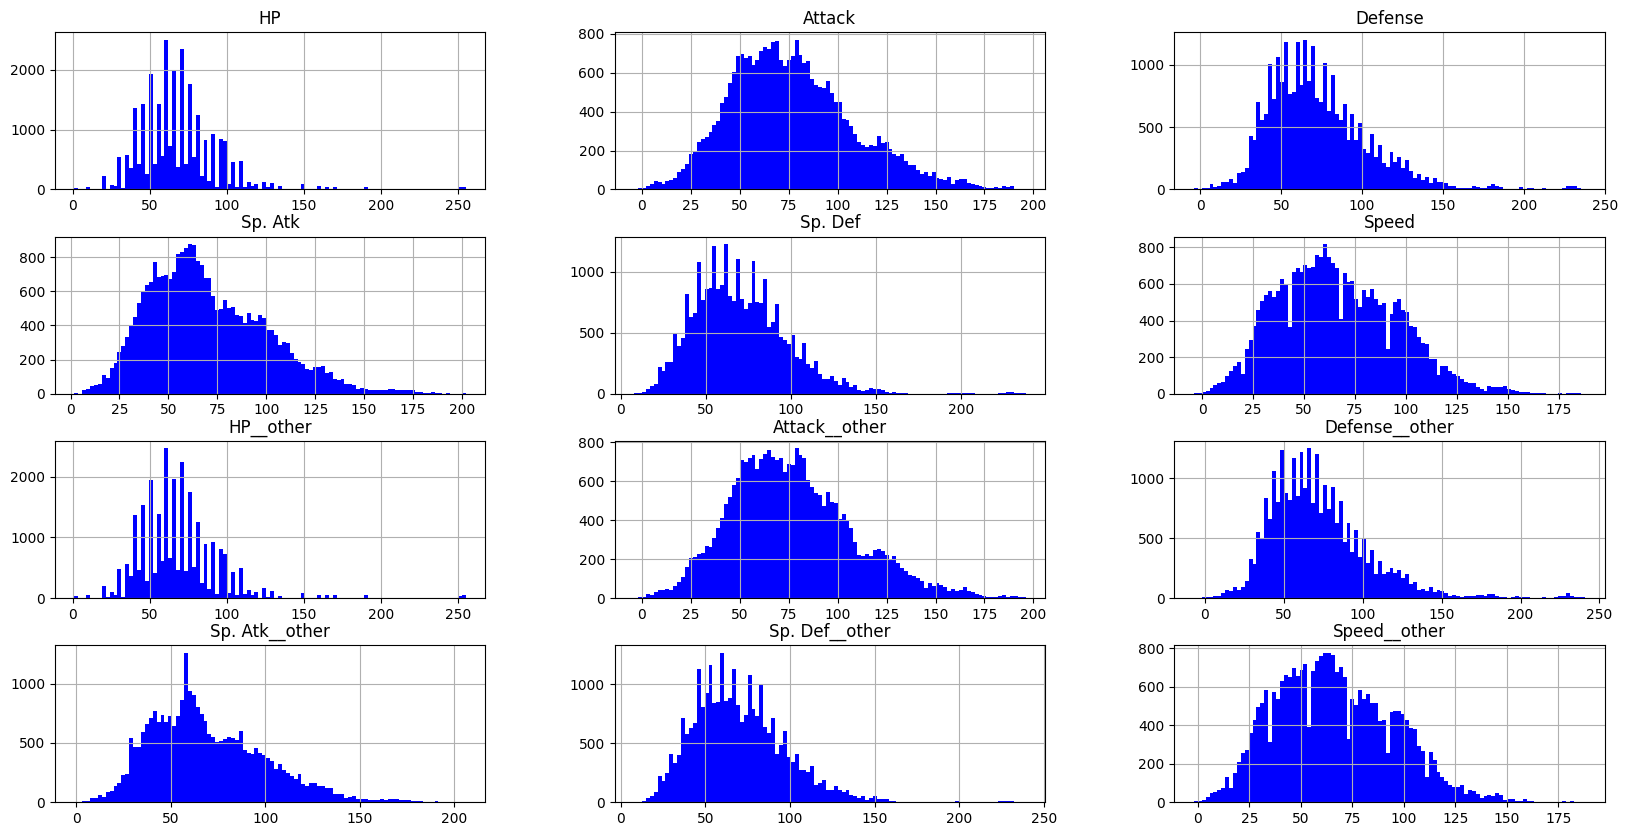

In [48]:
data_4.hist(bins=100, figsize=(20,10), color='b')  
plt.show()

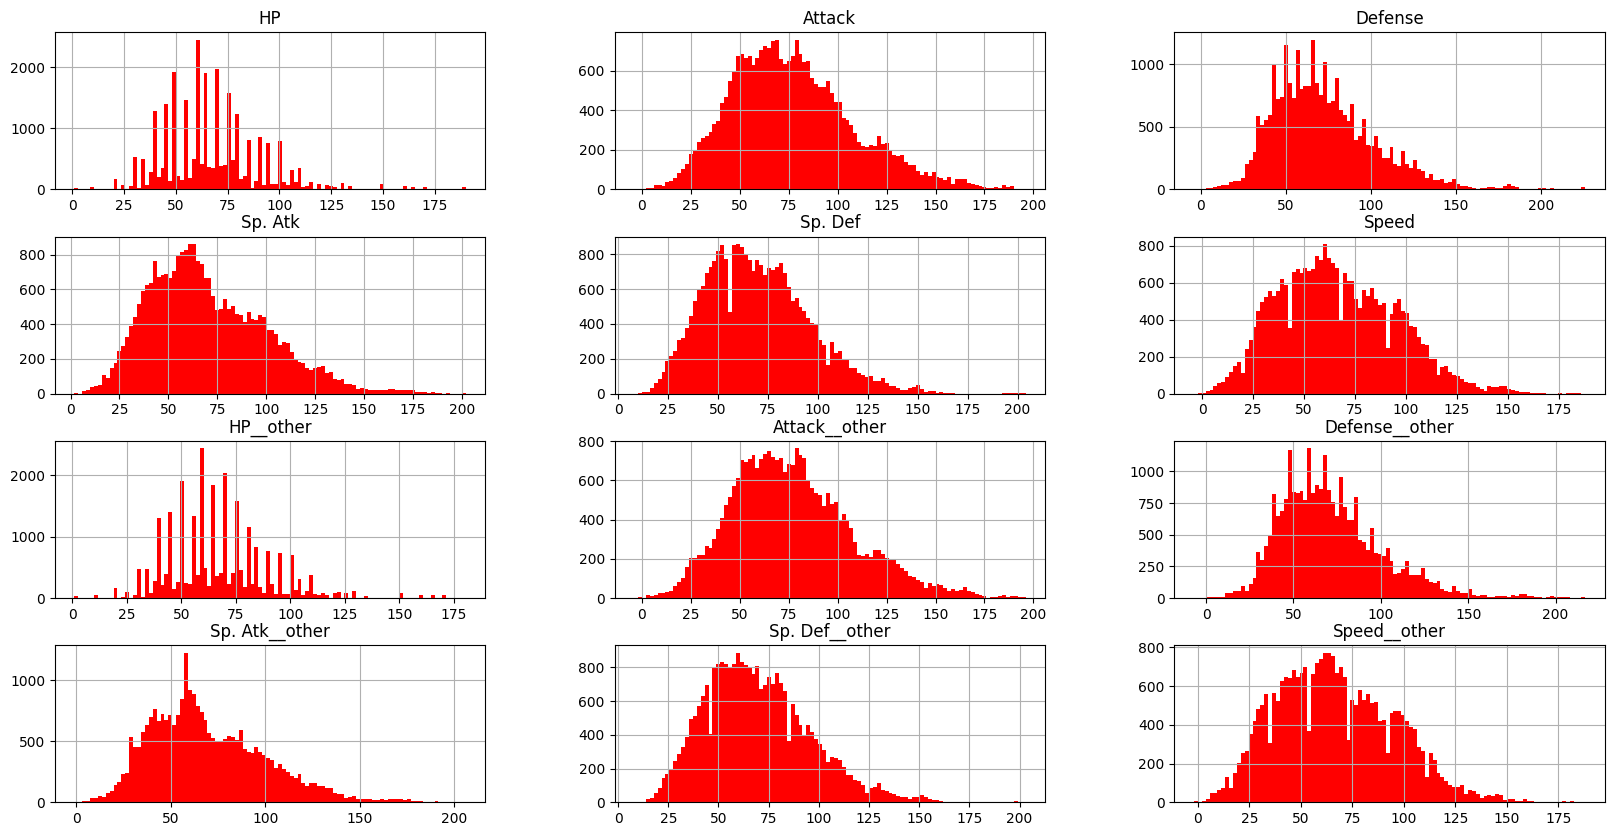

In [49]:
data_4_pc.hist(bins=100, figsize=(20,10), color='r')  
plt.show()

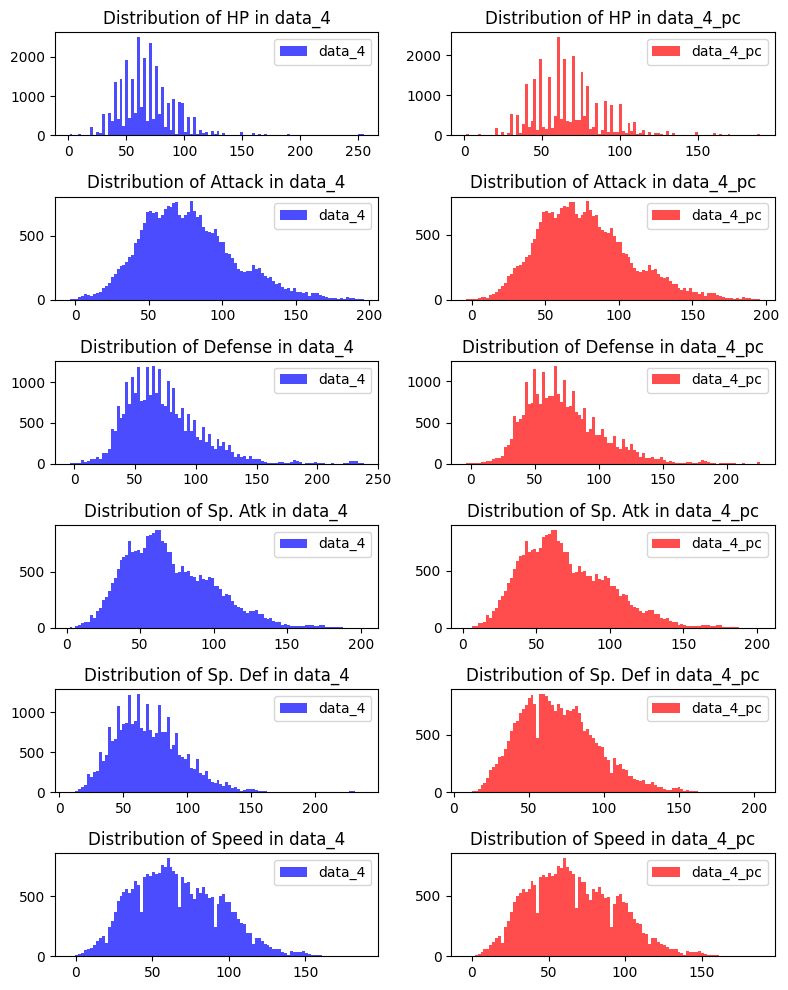

In [50]:
# Lista de columnas a comparar
columns_to_compare = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

# Configuración del gráfico
fig, axes = plt.subplots(nrows=len(columns_to_compare), ncols=2, figsize=(8, 10))

# Itera sobre las columnas y compara las distribuciones
for i, col in enumerate(columns_to_compare):
    # Histograma para data_4
    axes[i, 0].hist(data_4[col], bins=100, color='b', alpha=0.7, label='data_4')
    axes[i, 0].set_title(f'Distribution of {col} in data_4')
    axes[i, 0].legend()

    # Histograma para data_4_pc
    axes[i, 1].hist(data_4_pc[col], bins=100, color='r', alpha=0.7, label='data_4_pc')
    axes[i, 1].set_title(f'Distribution of {col} in data_4_pc')
    axes[i, 1].legend()

# Ajustes de diseño
plt.tight_layout()
plt.show()

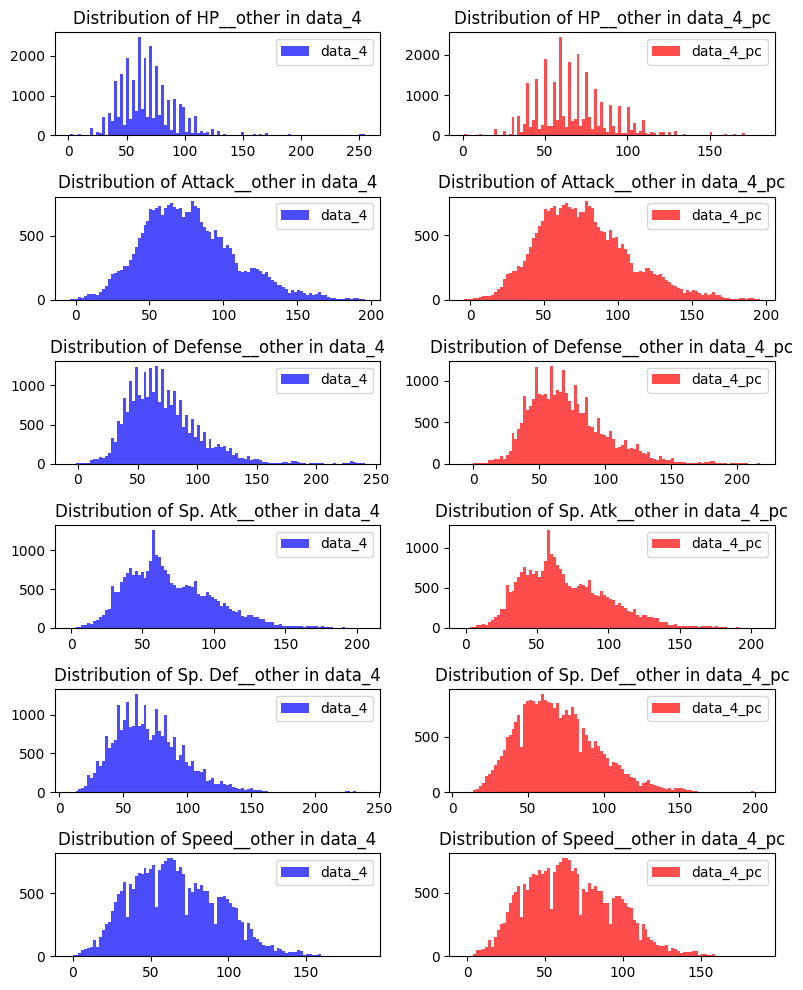

In [51]:
# Lista de columnas a comparar
columns_to_compare = ['HP__other', 'Attack__other', 'Defense__other', 'Sp. Atk__other', 'Sp. Def__other', 'Speed__other']

# Configuración del gráfico
fig, axes = plt.subplots(nrows=len(columns_to_compare), ncols=2, figsize=(8, 10))

# Itera sobre las columnas y compara las distribuciones
for i, col in enumerate(columns_to_compare):
    # Histograma para data_4
    axes[i, 0].hist(data_4[col], bins=100, color='b', alpha=0.7, label='data_4')
    axes[i, 0].set_title(f'Distribution of {col} in data_4')
    axes[i, 0].legend()

    # Histograma para data_4_pc
    axes[i, 1].hist(data_4_pc[col], bins=100, color='r', alpha=0.7, label='data_4_pc')
    axes[i, 1].set_title(f'Distribution of {col} in data_4_pc')
    axes[i, 1].legend()

# Ajustes de diseño
plt.tight_layout()
plt.show()

### 🔴 2.5 - Correlation matrix
**Problem**: ...    
**Objective**: ...      
**Process**: ...

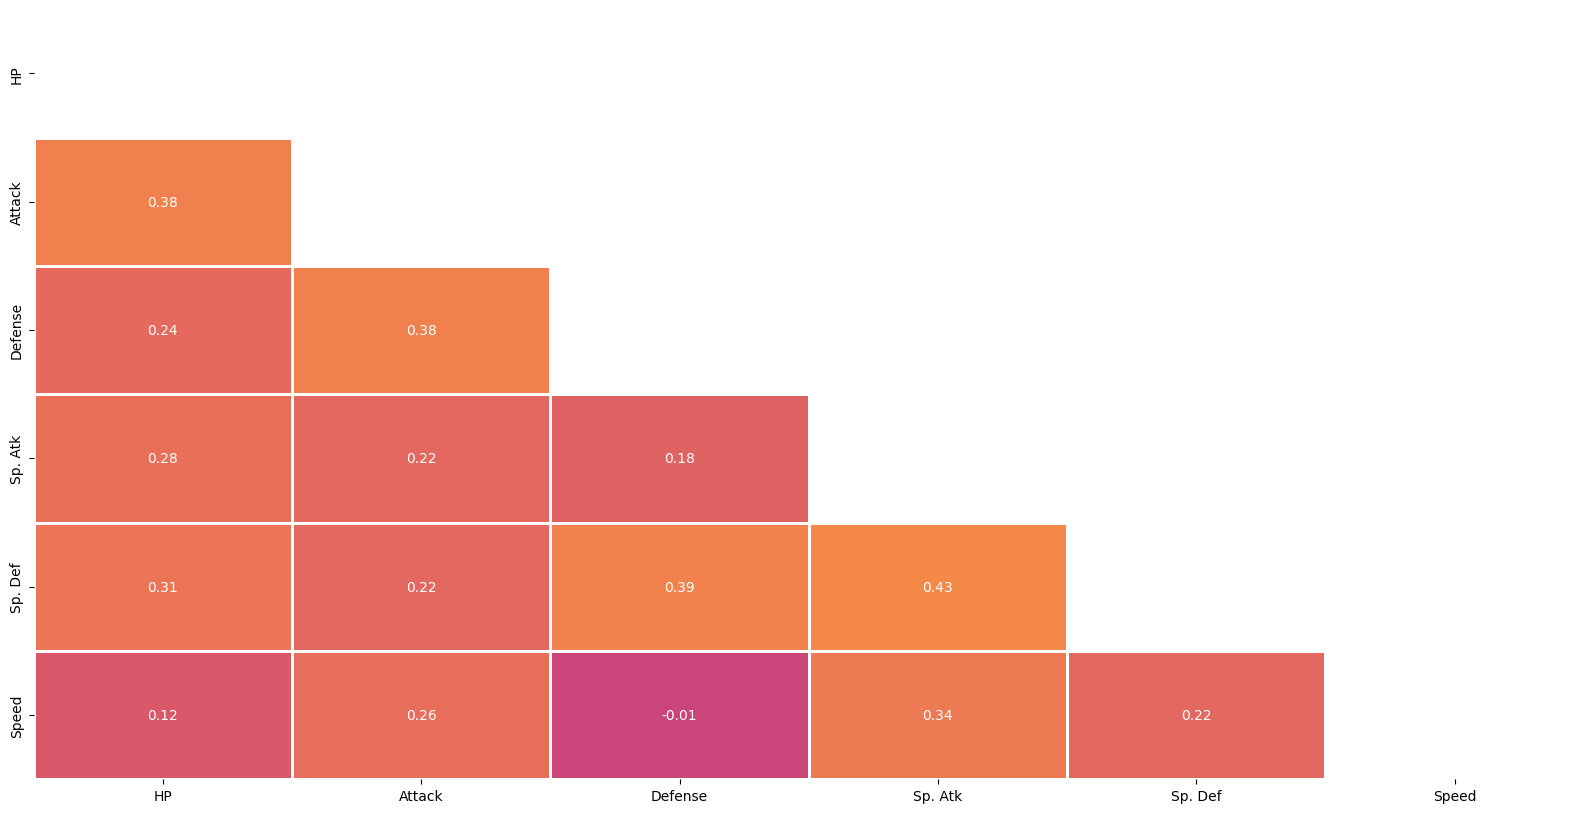

In [52]:
columns_to_include =  ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']   

# Calcular la matriz de correlación
corr_mat = data_4_pc[columns_to_include].corr().round(2)    

# Configuración del gráfico
plt.subplots(figsize = (20,10))
mask = np.zeros_like(corr_mat,dtype = bool)
mask[np.triu_indices_from(mask)] = True 

# Crear el mapa de calor
sns.heatmap(corr_mat,mask = mask,vmin = -1,vmax = 1,center = 0, cmap = 'plasma',square = False,lw = 2,annot = True,cbar = False)
plt.show() 


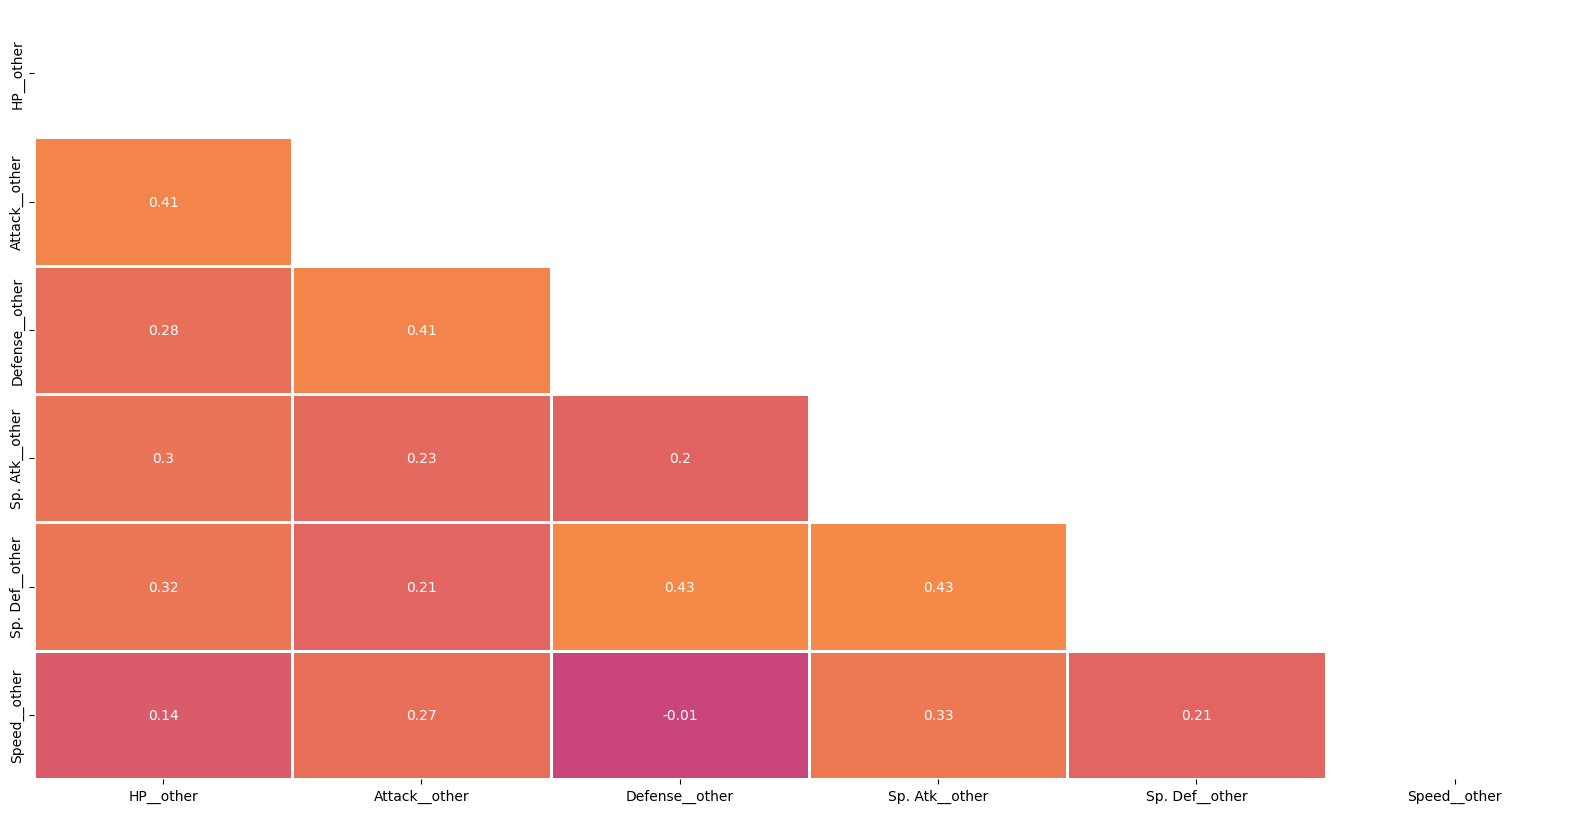

In [53]:
columns_to_include =  ['HP__other', 'Attack__other', 'Defense__other', 'Sp. Atk__other', 'Sp. Def__other', 'Speed__other']   

# Calcular la matriz de correlación
corr_mat = data_4_pc[columns_to_include].corr().round(2)    

# Configuración del gráfico
plt.subplots(figsize = (20,10))
mask = np.zeros_like(corr_mat,dtype = bool)
mask[np.triu_indices_from(mask)] = True 

# Crear el mapa de calor
sns.heatmap(corr_mat,mask = mask,vmin = -1,vmax = 1,center = 0, cmap = 'plasma',square = False,lw = 2,annot = True,cbar = False)
plt.show() 

In [ ]:
# Remove the columns that are can damage the model
# ... your code here

### 🟢 EXTRA - Change object per float

In [54]:
data_5 = data_4_pc.copy(deep=True)

In [55]:
data_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27080 entries, 39087 to 15795
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type 1            27080 non-null  object 
 1   Type 2            27080 non-null  object 
 2   HP                27080 non-null  float64
 3   Attack            27080 non-null  float64
 4   Defense           27080 non-null  float64
 5   Sp. Atk           27080 non-null  float64
 6   Sp. Def           27080 non-null  float64
 7   Speed             27080 non-null  float64
 8   Legendary         27080 non-null  bool   
 9   Type 1__other     27080 non-null  object 
 10  Type 2__other     27080 non-null  object 
 11  HP__other         27080 non-null  float64
 12  Attack__other     27080 non-null  float64
 13  Defense__other    27080 non-null  float64
 14  Sp. Atk__other    27080 non-null  float64
 15  Sp. Def__other    27080 non-null  float64
 16  Speed__other      27080 non-null  fl

In [56]:
# Columnas a convertir
columns_to_convert = ['Legendary', 'Legendary__other', 'Wins']

# Convertir True a 1 y False a 0 en las columnas seleccionadas
data_5[columns_to_convert] = data_5[columns_to_convert].astype(float)

data_5[columns_to_convert].head()

,Legendary,Legendary__other,Wins
39087,0.0,0.0,1.0
45278,0.0,0.0,1.0
16398,0.0,0.0,0.0
13653,0.0,0.0,0.0
14290,0.0,0.0,1.0


In [57]:
data_5['Type 1'].value_counts()

Water       3740
Normal      3248
Grass       2387
Bug         2295
Psychic     1749
Fire        1706
Rock        1491
Electric    1395
Poison      1172
Ghost       1102
Ground      1094
Fighting    1071
Dark        1005
Steel        917
Ice          834
Dragon       788
Fairy        671
Flying       415
Name: Type 1, dtype: int64

In [58]:
type_mapping = {
    "Water": 1,
    "Normal": 2,
    "Bug": 3,
    "Grass": 4,
    "Fire": 5,
    "Psychic": 6,
    "Rock": 7,
    "Electric": 8,
    "Ghost": 9,
    "Poison": 10,
    "Dark": 11,
    "Ground": 12,
    "Fighting": 13,
    "Steel": 14,      
    "Dragon": 15,
    "Ice": 16,
    "Fairy": 17,
    "Flying": 18,
}

data_5 = data_5.replace({
    'Type 1': type_mapping,
    'Type 2': type_mapping, 
    'Type 1__other': type_mapping, 
    'Type 2__other': type_mapping
    })

In [59]:
columns_to_convert = ['Type 1', 'Type 2', 'Type 1__other', 'Type 2__other']    
data_5[columns_to_convert] = data_5[columns_to_convert].astype(float)   
data_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27080 entries, 39087 to 15795
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type 1            27080 non-null  float64
 1   Type 2            27080 non-null  float64
 2   HP                27080 non-null  float64
 3   Attack            27080 non-null  float64
 4   Defense           27080 non-null  float64
 5   Sp. Atk           27080 non-null  float64
 6   Sp. Def           27080 non-null  float64
 7   Speed             27080 non-null  float64
 8   Legendary         27080 non-null  float64
 9   Type 1__other     27080 non-null  float64
 10  Type 2__other     27080 non-null  float64
 11  HP__other         27080 non-null  float64
 12  Attack__other     27080 non-null  float64
 13  Defense__other    27080 non-null  float64
 14  Sp. Atk__other    27080 non-null  float64
 15  Sp. Def__other    27080 non-null  float64
 16  Speed__other      27080 non-null  fl

### Conclusion  
... 


## Part 3 - Training your model (3 points)
In this part you have to train a **classifier** model to predict if a Pokemon will win or not a battle against another Pokemon. For this, you should explore at least 3 different classifiers.

You have to train and evaluate those classifiers using cross-validation in order to select the best one. Then, you should also study the results of the model (overfit, underfit, possible bias...).

1. Train (at least) 3 different classifiers
2. Evaluate the 3 classifiers using cross-validation. Select the best model according to this metric.
3. For the selected model: 
   1. Get the accuracy for data not seen during the training process
   2. Plot the confusion matrix
   3. Analize the results of accuracy and the confusion matrix

In [60]:
data_final = data_5.copy(deep=True)

In [61]:
# Train-test split    
x = data_final.drop(['Wins'], axis=1)
y = data_final['Wins']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=10)

### 3.1 - Logistic Regression

In [96]:
# Load model    
# lr = LogisticRegression(penalty = 'l2', C = 10, random_state = 0)
lr = LogisticRegression(random_state=40)
print(lr.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 40, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [97]:
lr.fit(x_train,y_train)

C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=40)

In [98]:
# First test prediction    
y_pred = lr.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy: {:d}%'.format(int(accuracy * 100)))

Accuracy: 82%


In [108]:
# Cross validation
scores = cross_val_score(lr, x_train, y_train, cv=10)
print("Accuracy: {:d}%".format(int(scores.mean() * 100)))

C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/m

Accuracy: 83%


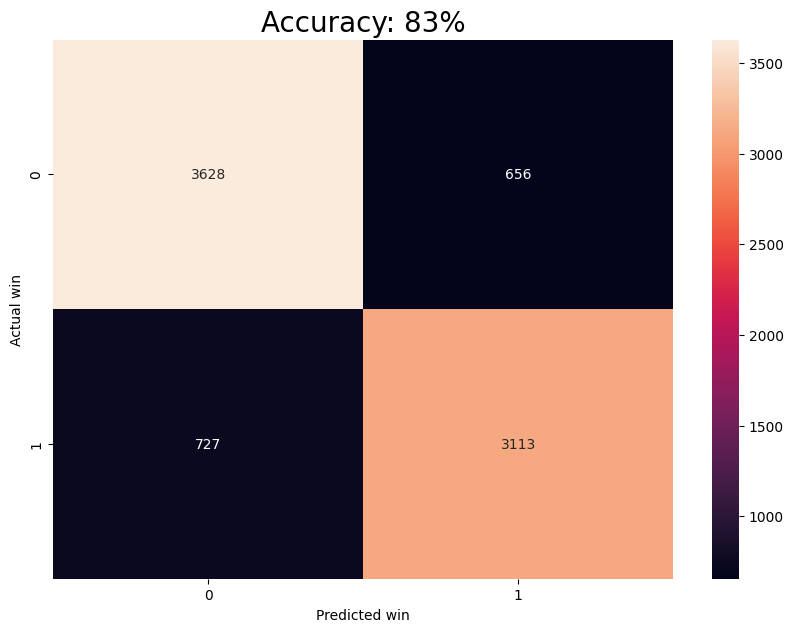

In [109]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f")
plt.xlabel('Predicted win')
plt.ylabel('Actual win')
plt.title('Accuracy: {:d}%'.format(int(scores.mean() * 100)), size = 20)
plt.show()

### 3.2 - Decision Tree

In [111]:
# Load model    

#dt = DecisionTreeClassifier(criterion='gini',splitter='best', max_depth=3)
# dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
# max_features=None, max_leaf_nodes=None,
# min_samples_leaf=1,
# min_samples_split=2, min_weight_fraction_leaf=0.0,
# random_state=None, splitter='best')
dt = DecisionTreeClassifier(criterion='gini',splitter='best')
print(dt.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [112]:
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [113]:
# tree.plot_tree(dt)
# plt.show()

In [114]:
# Fisrt test prediction    
y_pred = dt.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy: {:d}%'.format(int(accuracy * 100)))

Accuracy: 80%


In [115]:
# Cross validation
scores = cross_val_score(dt, x_train, y_train, cv=10)
print("Accuracy: {:d}%".format(int(scores.mean() * 100)))

Accuracy: 80%


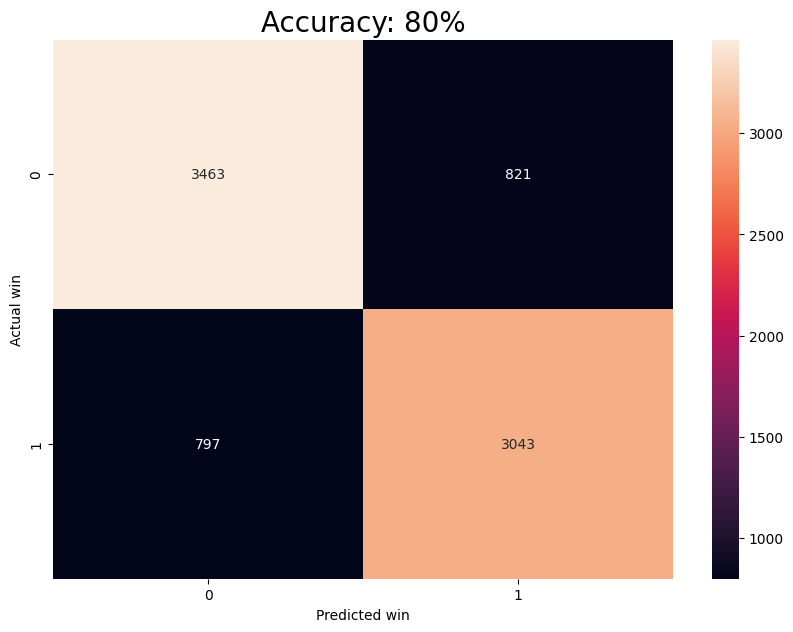

In [116]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f")
plt.xlabel('Predicted win')
plt.ylabel('Actual win')
plt.title('Accuracy: {:d}%'.format(int(scores.mean() * 100)), size = 20)
plt.show()

### 3.3 - Random Forest

In [92]:
#rfc = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt', max_depth= 200, bootstrap=False, random_state=0) 
rfc = RandomForestClassifier(n_estimators=1000, random_state=0)
print(rfc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [93]:
rfc.fit(x_train,y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree

# fig = plt.figure(figsize=(15, 10))
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
# plot_tree(rfc.estimators_[0],  
#           filled=True, impurity=True, 
#           rounded=True)

In [94]:
# First test prediction    
y_pred_rfc = rfc.predict(x_test)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print('Accuracy: {:d}%'.format(int(accuracy_rfc * 100)))

Accuracy: 87%


In [117]:
# Cross validation
scores = cross_val_score(rfc, x_train, y_train, cv=10)
print("Accuracy: {:d}%".format(int(scores.mean() * 100)))

Accuracy: 87%


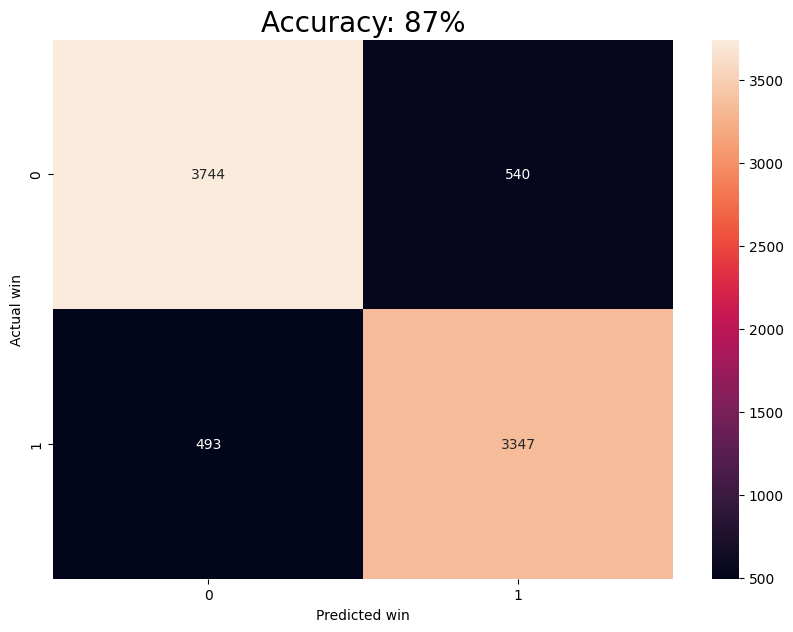

In [118]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred_rfc), annot=True, fmt=".0f")
plt.xlabel('Predicted win')
plt.ylabel('Actual win')
plt.title('Accuracy: {:d}%'.format(int(scores.mean() * 100)), size = 20)
plt.show()

## Part 4 (Optional) - Create an ensemble and configure the model

You have trained different classifiers but selected only one of them as "the best" one. Maybe instead of having the models competing between them, having them to colaborate would yield better results. 

We propose you to create an ensemble of the different classifiers explored in *Part 3*. You should compare the ensemble with the individual models using cross-validation, and then get the final accuracy and the confusion matrix for the ensemble.
As a bonus, try to tune the parameters of this ensemble using either `GridSearchCV` or `RandomizedSearchCV`.

1. Train an ensemble with the classifiers in *Part 3*.
2. Compare the performance of this ensemble using cross-validation, the final accuracy, and the confusion matrix. Analyze the results.
3. Fine-tune the hyper-parameters of the ensemble using `GridSearchCV` or `RandomizedSearchCV`.

In [119]:
from sklearn.ensemble import VotingClassifier

# Logistic regression, decision tree y random forest
ensemble = VotingClassifier(estimators=[('lr', lr), ('dt', dt), ('rf', rfc)], voting='hard')

# Entrenar todos los modelos juntos
ensemble.fit(x_train, y_train)

C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=40)),
                             ('dt', DecisionTreeClassifier()),
                             ('rf',
                              RandomForestClassifier(n_estimators=1000,
                                                     random_state=0))])

In [120]:
# Cross validation
cv_scores = cross_val_score(ensemble, x_train, y_train, cv=10, scoring='accuracy')

# Imprime los resultados
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/m

Cross-Validation Scores: [0.86075949 0.86656118 0.86445148 0.86814346 0.86708861 0.86445148
 0.85435356 0.86807388 0.86015831 0.87387863]
Mean Accuracy: 0.8647920076149761


Final Accuracy of Ensemble: 0.8632447070408665
Confusion Matrix of Ensemble:
 [[3716  568]
 [ 543 3297]]


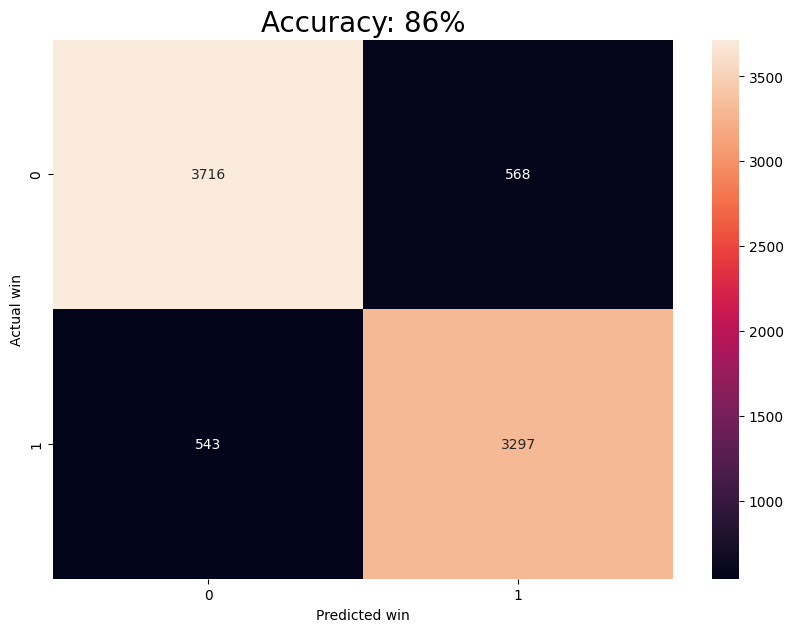

In [123]:
# Hacer predicciones en el conjunto de prueba
y_pred_ensemble = ensemble.predict(x_test)

# Calcular la precisión final
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print("Final Accuracy of Ensemble:", accuracy_ensemble)

# Calcular la matriz de confusión
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
print("Confusion Matrix of Ensemble:\n", conf_matrix_ensemble)  

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred_ensemble), annot=True, fmt=".0f")
plt.xlabel('Predicted win')
plt.ylabel('Actual win')
plt.title('Accuracy: {:d}%'.format(int(accuracy_ensemble * 100)), size = 20)
plt.show()

In [124]:
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a ajustar
param_grid = {
    'lr__C': [0.1, 1, 10],  # Hiperparámetros de Logistic Regression
    'dt__max_depth': [None, 10, 20],  # Hiperparámetros de Decision Tree
    'rf__n_estimators': [50, 100, 200]  # Hiperparámetros de Random Forest
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=ensemble, param_grid=param_grid, cv=5, scoring='accuracy')

# Realizar la búsqueda de hiperparámetros
grid_search.fit(x_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/m

Best Hyperparameters: {'dt__max_depth': 10, 'lr__C': 1, 'rf__n_estimators': 200}


## Part 5 - Wrap-up (2 points)
The final part of this assignment is to wrap-up your classifier into a pipeline. This pipeline will execute the entire process:

- Preprocess the data
    - Select features
    - Impute data
    - Encode values
- The classifier selected in *Part 3* (or the ensemble if it is better)

This pipeline will be used in the other provided notebook to generate the predictions for the combats you have to submit.

To ensure everything works as expected, we recommend you to load the dataset again before using it with the pipeline. You should also compare the accuracy and the confusion matrix from the pipeline with the model trained before. **Remember to set the random state to all the required transformers and estimators to have a constant output**.

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [128]:
numeric_features = ["Type 1", "Type 2", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed", "Legendary",
                    "Type 1__other", "Type 2__other", "HP__other", "Attack__other", "Defense__other", "Sp. Atk__other", "Sp. Def__other", "Speed__other", "Legendary__other",
                    "Wins"]

In [133]:
# Define las transformaciones para datos numéricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [134]:
# Combina las transformaciones
preprocessor = numeric_transformer

# Crea el pipeline con el preprocesamiento y el clasificador o ensemble
mypipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ensemble)  # Reemplaza ensemble con tu modelo seleccionado o ensemble
])

In [135]:
# Entrena el pipeline en tus datos
mypipeline.fit(x_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_pipeline = mypipeline.predict(x_test)

In [136]:
# Calcular la precisión final
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)
print("Final Accuracy of Pipeline:", accuracy_pipeline)

# Calcular la matriz de confusión
conf_matrix_pipeline = confusion_matrix(y_test, y_pred_pipeline)
print("Confusion Matrix of Pipeline:\n", conf_matrix_pipeline)

Final Accuracy of Pipeline: 0.8645987198424422
Confusion Matrix of Pipeline:
 [[3723  561]
 [ 539 3301]]
